In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stat
from matplotlib import rc
from scipy.optimize import linprog

## Exercise 1

<font size=4>
Sampling the uncertain parameter $H$ and $a$ with size $M=100 000$ (as validation set)

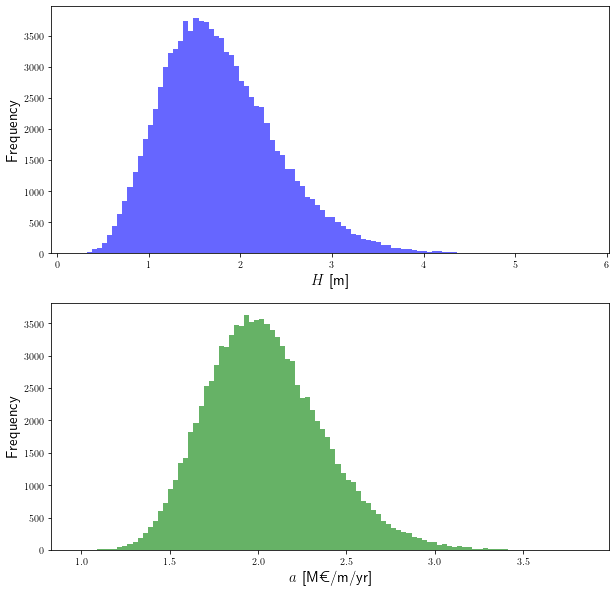

In [2]:
# Sample the H~Gamma and a~Lognormal distributions and computer the economic loss, plot their histograms

rc('text', usetex=True)
msize = 100000
binsize = 100
shape = 8
beta = 4.5
Hrnd_vali = stat.gamma.rvs(shape, scale=1/beta, size=msize)
mu = 0.7
sigma = 0.16
arnd_vali = stat.lognorm.rvs(sigma, loc=0, scale=np.exp(mu), size=msize)

fig, ax = plt.subplots(2,1,figsize=(10,10),sharex=False)
ax[0].hist(Hrnd_vali, bins = binsize, facecolor='b', alpha=0.6)
ax[0].set_xlabel('$H$ [m]',fontsize=15)
ax[0].set_ylabel('Frequency',fontsize=15)
ax[1].hist(arnd_vali, bins = binsize, facecolor='g', alpha=0.6, label='Lornorm')
ax[1].set_xlabel(r'$a$ [M\texteuro/m/yr]',fontsize=15)
ax[1].set_ylabel('Frequency',fontsize=15)
plt.show()

<font size=4>
(1) Assume the objective is to select an optimal dike height so that the summation of the investment cost and the expected economic loss is minimized. Formulate the sample average approximation problem, and solve it with different sample sizes and validate your choice using out-of-sample validation

In [3]:
# Sampled average approximation problem first we sample different sets of sample N=10, 100, 500, and use the 
# sample generated previously as a validation set
nsize = [10, 50, 500] # different sizes of samples
Hrnd = []
arnd = []
for i in range(len(nsize)):
    H = stat.gamma.rvs(shape, scale=1/beta, size=nsize[i])
    a = stat.lognorm.rvs(sigma, loc=0, scale=np.exp(mu), size=nsize[i])
    Hrnd.append(H)
    arnd.append(a)

In [7]:
# This dcp_saa_linprog function will format the parameters and call the linear programming solver (linprog)
def dcp_saa_linprog(a,H,N):
    # the variable bounds, LP object vector c, inequality constraint matrix A, and the inequality constraint vector b
    xbounds = (0, 3)
    hbounds = [(0, None) for i in range(N)]
    bds = hbounds
    bds.insert(0, xbounds)    
    c = np.append(0.9, a/N) 
    A = np.concatenate((np.c_[-np.ones(N)], np.diag(-np.ones(N))), axis=1)  
    b = -H
    #np.set_printoptions(precision=2)
    #print("Objective vector = ",c)
    #print(A)
    #print("Inequality vector = ",b)
    #print("Variable bounds = ", str(hbounds))
    res = linprog(c, A_ub=A, b_ub=b, bounds=bds, method='revised simplex')
    return res

res = []
for i in range(len(nsize)):
    res.append(dcp_saa_linprog(arnd[i], Hrnd[i], nsize[i]))
    print("SAA"+str(i)+" result: ", res[i].success)
    print('Optimal dike height: %.4f [m]' % res[i].x[0], 'with expected total cost %.4f [Meuro/yr]' % res[i].fun)

SAA0 result:  True
Optimal dike height: 1.4159 [m] with expected total cost 1.7767 [Meuro/yr]
SAA1 result:  True
Optimal dike height: 1.6648 [m] with expected total cost 1.9919 [Meuro/yr]
SAA2 result:  True
Optimal dike height: 1.7441 [m] with expected total cost 1.9961 [Meuro/yr]


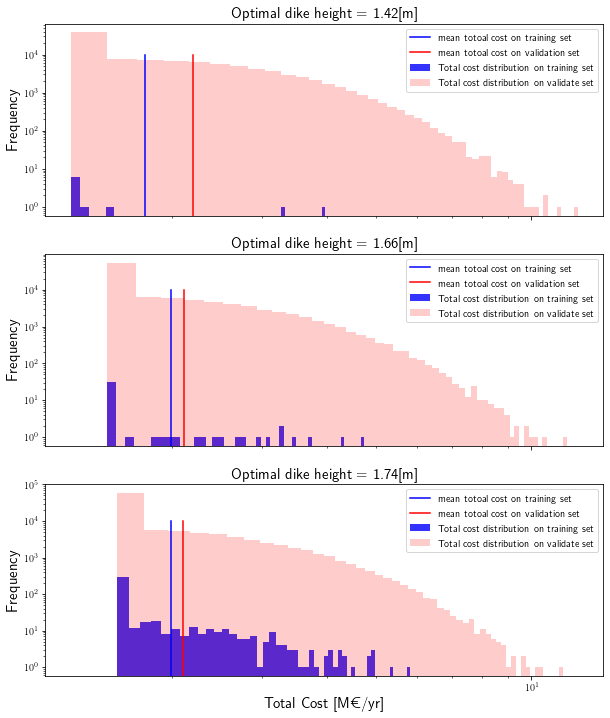

 x      C_trng C_vali
[1.4159 1.7767 2.2008]
[1.6648 1.9919 2.1161]
[1.7441 1.9961 2.1068]


In [8]:
# validate the results using Out-of-Sample validation

def dcpvalidate(x, vali_a, vali_H):
    if len(vali_a) != len(vali_H):
        return -1
    M = len(vali_a)
    c = 0.9*x + np.multiply(vali_a, np.maximum(0, [h-x for h in vali_H])) 
    cmean = 0.9*x + 1/M * np.sum( np.multiply(vali_a, np.maximum(0, [h-x for h in vali_H])) )
    return cmean,c

trngCost = []
valiObj = []
valiCost = []
for i in range(len(nsize)): 
    # distributions on training samples
    _, trngCost_tmp = dcpvalidate(res[i].x[0], np.array(arnd[i]), np.array(Hrnd[i]))
    trngCost.append(trngCost_tmp)   
    # validation results (expected total cost and its distribution)
    valiObj_tmp, valiCost_tmp = dcpvalidate(res[i].x[0], np.array(arnd_vali), np.array(Hrnd_vali))
    valiObj.append(valiObj_tmp)
    valiCost.append(valiCost_tmp)

# visulize the results
binsize = 50
fig, ax = plt.subplots(len(nsize),1,figsize=(10,4*len(nsize)),sharex=True)
for i in range(len(nsize)):
    ax[i].hist(trngCost[i], bins = binsize, facecolor='b', alpha=0.8, label="Total cost distribution on training set")
    ax[i].hist(valiCost[i], bins = binsize, facecolor='r', alpha=0.2, label="Total cost distribution on validate set")
    ax[i].plot(res[i].fun*np.ones((2,1)),(0,10**4),'b',label='mean totoal cost on training set')
    ax[i].plot(valiObj[i]*np.ones((2,1)),(0,10**4),'r',label='mean totoal cost on validation set')
    ax[i].set_ylabel('Frequency',fontsize=15)
    ax[i].set_title('Optimal dike height = '+str("{:.2f}".format(res[i].x[0]))+'[m]', fontsize = 15)
    ax[i].set_yscale('log') 
    ax[i].set_xscale('log')
    ax[i].legend()
    if i == len(nsize)-1:
        ax[i].set_xlabel(r'Total Cost [M\texteuro/yr]',fontsize=15)
plt.show()

np.set_printoptions(precision=4)
print(" x      C_trng C_vali")
for i in range(len(nsize)):
    print(np.array([res[i].x[0], res[i].fun, valiObj[i]]))

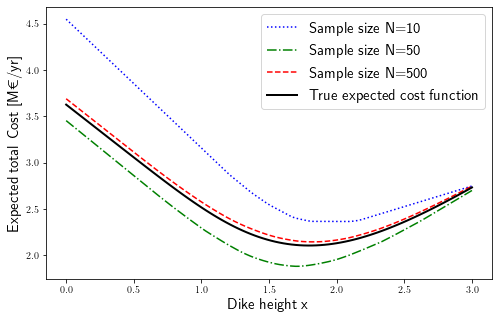

In [8]:
# visulize the estimated expected cost function associated with each sampled model
# and compare them with the true expected cost function
numx = 100
x = np.linspace(0, 3.0, num=numx)
totCost = []
for i in range(len(nsize)):
    h = np.tile(np.array([Hrnd[i]]).T, (1, numx)) - x
    h = h.clip(min=0)
    tc = 0.9*x + 1/nsize[i]*np.sum( np.multiply(h, np.tile(np.array([arnd[i]]).T, (1, numx)) ), axis=0)
    totCost.append(tc)

H_cond_expect = np.zeros(numx)
for i in range(numx):
    H_cond_expect[i] = stat.gamma.expect(lambda h: h-x[i], args=(shape,), scale=1/beta, lb = x[i], conditional=True)
trueCost = 0.9*x + np.exp(mu+0.5*sigma**2)* np.multiply(H_cond_expect,(1-stat.gamma.cdf(x, shape, scale=1/beta)))

fig, ax = plt.subplots(figsize=(8,5))
linespec = [':b','-.g','--r']
for i in range(len(nsize)):
    plt.plot(x,totCost[i],linespec[i],label='Sample size N='+str(nsize[i]))
plt.plot(x,trueCost,'k',linewidth=2,label='True expected cost function')  
ax.set_xlabel('Dike height x',fontsize=15)
ax.set_ylabel(r'Expected total Cost [M\texteuro/yr]',fontsize=15)
ax.legend(fontsize=15)
plt.show()

<font size=4>
(2) Suppose we want to control the tail risk by minimizing the CVaR of the total cost (investment cost + economic loss), formulate the optimization problem and solve it with the sample set your chosen in problem (2). Compare the results with problem (2)

In [12]:
# We can choose different confidence level alpha
alpha = [0.80, 0.88, 0.95]

# This dcp_cvar_linprog function will format the parameters and call the linear programming 
def dcp_cvar_linprog(a, H, N, alpha):
    # the variable bounds, LP object vector c, inequality constraint matrix A, and the inequality constraint vector b
    x_bds = (0, 3)
    gamma_bds = (None, None)
    hz_bds = [(0, None) for i in range(2*N)]
    bds = hz_bds
    bds.insert(0, gamma_bds)
    bds.insert(0, x_bds) 
    c = np.concatenate(([0, 1], np.zeros(N), np.ones(N)/(1-alpha)/N), axis=None)
    A1 = np.concatenate((-np.ones((N,1)), np.zeros((N,1)), np.diag(-np.ones(N)), np.zeros((N,N)) ), axis=1)  
    A2 = np.concatenate((0.9*np.ones((N,1)), -np.ones((N,1)), np.diag(np.array(a)), np.diag(-np.ones(N)) ), axis=1)
    A = np.concatenate((A1,A2),axis=0)
    b = np.concatenate( (-np.array(H), np.zeros(N)), axis = 0)
    #np.set_printoptions(precision=2)
    #print("Objective vector = ",c)
    #print(A)
    #print("Inequality vector = ",b)
    #print("Variable bounds = ", str(bds))
    res = linprog(c, A_ub=A, b_ub=b, bounds=bds, method='revised simplex')
    return res

# solve the LP for different confidence level alpha with the largest sample size
lastInd = len(nsize)-1
cvar_res = []
for i in range(len(alpha)):
    cvar_res.append(dcp_cvar_linprog(arnd[lastInd], Hrnd[lastInd], nsize[lastInd],alpha[i]))
    print("CVaR("+str(alpha[i])+") minimization result: ", cvar_res[i].success)
    print('Optimal dike height: %.4f [m]' % cvar_res[i].x[0], 'with expected tail cost %.4f [Meuro/yr]' % cvar_res[i].fun)

CVaR(0.8) minimization result:  True
Optimal dike height: 2.5312 [m] with expected tail cost 2.5858 [Meuro/yr]
CVaR(0.88) minimization result:  True
Optimal dike height: 2.7178 [m] with expected tail cost 2.7361 [Meuro/yr]
CVaR(0.95) minimization result:  True
Optimal dike height: 3.0000 [m] with expected tail cost 2.9495 [Meuro/yr]


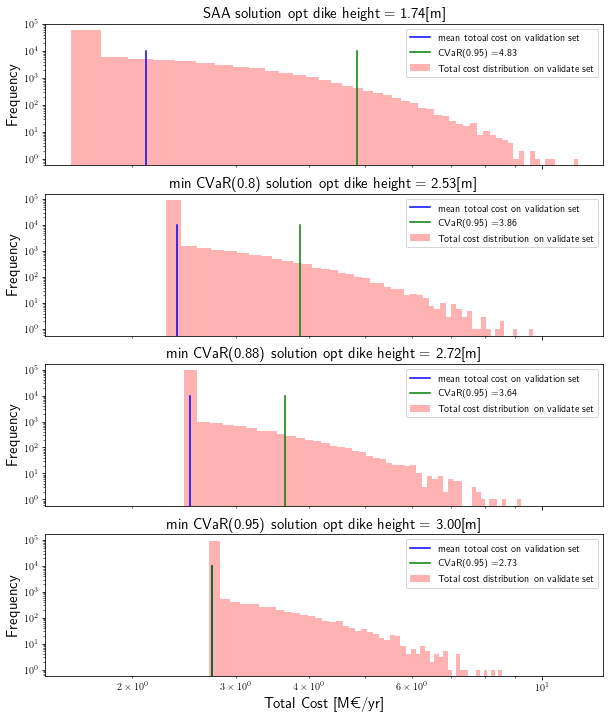

In [11]:
# calculate the expected cost and its distribution of the CVaR solution
averCost_cvar = []
cost_cvar = []
cvar = np.zeros(len(alpha))
for i in range(len(alpha)): 
    averCost_cvar_tmp, cost_cvar_tmp = dcpvalidate(cvar_res[i].x[0], np.array(arnd_vali), np.array(Hrnd_vali))
    averCost_cvar.append(averCost_cvar_tmp)
    cost_cvar.append(cost_cvar_tmp)
    var = np.quantile(cost_cvar_tmp, 0.95, interpolation='higher')
    cvar[i] = cost_cvar_tmp[cost_cvar_tmp >= var].mean()

var_lastInd = np.quantile(valiCost[lastInd], 0.95, interpolation='higher')
cvar_lastInd = valiCost[lastInd][valiCost[lastInd]>=var_lastInd].mean()

# visulize the results
binsize = 50
fig, ax = plt.subplots(len(alpha)+1, 1, figsize=(10,3*(len(alpha)+1)),sharex=True)
ax[0].hist(valiCost[lastInd], bins = binsize, facecolor='r', alpha=0.3, label="Total cost distribution on validate set")
ax[0].plot(valiObj[lastInd]*np.ones((2,1)),(0,10**4),'b',label='mean totoal cost on validation set')
ax[0].plot(cvar_lastInd*np.ones((2,1)),(0,10**4),'g',label='CVaR(0.95) ='+str("{:.2f}".format(cvar_lastInd)))
ax[0].set_ylabel('Frequency',fontsize=15)
ax[0].set_title('SAA solution opt dike height = '+str("{:.2f}".format(res[lastInd].x[0]))+'[m]', fontsize = 15)
ax[0].set_yscale('log') 
ax[0].set_xscale('log')
ax[0].legend()
for i in range(len(alpha)):
    ax[i+1].hist(cost_cvar[i], bins = binsize, facecolor='r', alpha=0.3, label="Total cost distribution on validate set")
    ax[i+1].plot(averCost_cvar[i]*np.ones((2,1)),(0,10**4),'b',label='mean totoal cost on validation set')
    ax[i+1].plot(cvar[i]*np.ones((2,1)),(0,10**4),'g',label='CVaR(0.95) ='+str("{:.2f}".format(cvar[i])))
    ax[i+1].set_ylabel('Frequency',fontsize=15)
    ax[i+1].set_title('min CVaR('+str(alpha[i])+') solution opt dike height = \
                      '+str("{:.2f}".format(cvar_res[i].x[0]))+'[m]', fontsize = 15)
    ax[i+1].set_yscale('log') 
    ax[i+1].set_xscale('log')
    ax[i+1].legend()
    if i == len(nsize)-1:
        ax[i+1].set_xlabel(r'Total Cost [M\texteuro/yr]',fontsize=15)
plt.show()